In [1]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 驱虫市场潜力分析

In [2]:
# 切换目录
os.chdir('E:\深圳千锋\coding\data\驱虫剂市场')

In [3]:
filenames1 = glob.glob("*市场近三年交易额.xlsx")
filenames1

['灭鼠杀虫剂市场近三年交易额.xlsx',
 '电蚊香套装市场近三年交易额.xlsx',
 '盘香灭蟑香蚊香盘市场近三年交易额.xlsx',
 '蚊香加热器市场近三年交易额.xlsx',
 '蚊香液市场近三年交易额.xlsx',
 '蚊香片市场近三年交易额.xlsx',
 '防霉防蛀片市场近三年交易额.xlsx']

In [4]:
# 回顾一下re.search()方法
re.search(r'.*(?=市场)','灭鼠杀虫剂市场近三年交易额.xlsx').group()

'灭鼠杀虫剂'

- 定义函数，读取单个excel文件，转换成DataFrame,改变列名，
  时间列变为datetime类型，并将时间列变为index

In [5]:
def read_3threes(filename):
    colname = re.search(r'.*(?=市场)',filename).group() # 提取文件名中“市场”前面的文字
    df = pd.read_excel(filename) 
    if df['时间'].dtypes == 'int64':
        # 将“时间”列的数据类型转变为datetime类型
        df['时间'] = pd.to_datetime(df['时间'],unit='D',origin=pd.Timestamp('1899-12-30'))
    df.rename(columns={df.columns[1]:colname},inplace=True) # 修改第二列的列名
    df.set_index('时间',inplace=True)
    return df
    

In [6]:
# 分别读取七个文件，并转换成DataFrame,存入列表中
dfs = [read_3threes(filename) for filename in filenames1]

In [7]:
# 将7个DataFrame在axis=1的方向拼接
df = pd.concat(dfs,axis=1).reset_index()
df.head()

,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,2018-10-01,1.136548e+08,106531.29,4171283.35,315639.48,7814546.15,1032414.29,8541153.59
1,2018-09-01,1.440261e+08,105666.63,6784500.17,457366.41,10654973.47,1566651.88,8825870.43
2,2018-08-01,1.540426e+08,201467.03,10709683.41,746513.13,17835577.80,2617149.00,6320153.44
3,2018-07-01,1.480032e+08,438635.29,16589184.89,1871757.00,38877917.83,6209040.06,6302595.06
4,2018-06-01,1.359438e+08,953749.78,23526385.73,3641025.92,76499091.86,12484919.63,7047206.98


- 查看各列的数据缺失情况

In [8]:
df.isna().mean()

时间          0.0
灭鼠杀虫剂       0.0
电蚊香套装       0.0
盘香灭蟑香蚊香盘    0.0
蚊香加热器       0.0
蚊香液         0.0
蚊香片         0.0
防霉防蛀片       0.0
dtype: float64

- 抽取df的所有月份，以供后面使用

In [9]:
month = df['时间'].dt.month
month

0     10
1      9
2      8
3      7
4      6
5      5
6      4
7      3
8      2
9      1
10    12
11    11
12    10
13     9
14     8
15     7
16     6
17     5
18     4
19     3
20     2
21     1
22    12
23    11
24    10
25     9
26     8
27     7
28     6
29     5
30     4
31     3
32     2
33     1
34    12
35    11
Name: 时间, dtype: int64

- 循环预测2018年11月、12月各子类目的销售额

In [10]:
dm_test = df[month==11]
dm_test

,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
11,2017-11-01,58382172.96,94993.76,1581530.20,168141.79,4257593.87,617094.94,5447184.43
23,2016-11-01,47806248.76,106291.23,1473418.20,82835.82,2758827.44,512990.23,4975519.21
35,2015-11-01,33038726.31,185094.22,1197791.27,86889.91,1579795.72,325744.43,3364112.14


In [11]:
for i in [11,12]:
    dm = df[month==i] # 从df中抽取对应月份的记录
    Xtrain = np.array(dm['时间'].dt.year).reshape(-1,1)
    y_hat = [pd.datetime(2018,i,1)]
    for j in range(1,len(dm.columns)):  # 遍历对应月份的每个种类
        ytrain = np.array(dm.iloc[:,j])  # 获取对应种类的交易金额，作为训练样本集标签
        reg = LinearRegression()
        reg.fit(Xtrain,ytrain)
        y_predict = reg.predict(np.array([2018]).reshape(-1,1))
        y_hat.append(y_predict)
    newrow = pd.DataFrame(dict(zip(df.columns,y_hat)))
    df = newrow.append(df)  # 将预测的结果加到df中

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [13]:
df.reset_index(drop=True,inplace=True) # 删除原索引，重置索引

In [14]:
df.head()

,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,2018-12-01,5.256763e+07,50204.53,9.285543e+05,86849.166667,3.081492e+06,4.268126e+05,3958717.58
1,2018-11-01,7.175250e+07,38692.61,1.801319e+06,193874.386667,5.543204e+06,7.766270e+05,6678677.55
2,2018-10-01,1.136548e+08,106531.29,4.171283e+06,315639.480000,7.814546e+06,1.032414e+06,8541153.59
3,2018-09-01,1.440261e+08,105666.63,6.784500e+06,457366.410000,1.065497e+07,1.566652e+06,8825870.43
4,2018-08-01,1.540426e+08,201467.03,1.070968e+07,746513.130000,1.783558e+07,2.617149e+06,6320153.44


- 删除2015年的记录

In [15]:
df = df[df['时间'].dt.year!=2015]

- 添加新列，用来存储每年的交易金额总和

In [19]:
df['colsum'] = df.sum(1)
df.head()

,时间,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2018-12-01,5.256763e+07,50204.53,9.285543e+05,86849.166667,3.081492e+06,4.268126e+05,3958717.58,6.110026e+07
1,2018-11-01,7.175250e+07,38692.61,1.801319e+06,193874.386667,5.543204e+06,7.766270e+05,6678677.55,8.678489e+07
2,2018-10-01,1.136548e+08,106531.29,4.171283e+06,315639.480000,7.814546e+06,1.032414e+06,8541153.59,1.356363e+08
3,2018-09-01,1.440261e+08,105666.63,6.784500e+06,457366.410000,1.065497e+07,1.566652e+06,8825870.43,1.724211e+08
4,2018-08-01,1.540426e+08,201467.03,1.070968e+07,746513.130000,1.783558e+07,2.617149e+06,6320153.44,1.924731e+08


- 插入一个年分列'year'

In [20]:
df.insert(1,'year',df['时间'].dt.year)

In [22]:
df.head()

,时间,year,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2018-12-01,2018,5.256763e+07,50204.53,9.285543e+05,86849.166667,3.081492e+06,4.268126e+05,3958717.58,6.110026e+07
1,2018-11-01,2018,7.175250e+07,38692.61,1.801319e+06,193874.386667,5.543204e+06,7.766270e+05,6678677.55,8.678489e+07
2,2018-10-01,2018,1.136548e+08,106531.29,4.171283e+06,315639.480000,7.814546e+06,1.032414e+06,8541153.59,1.356363e+08
3,2018-09-01,2018,1.440261e+08,105666.63,6.784500e+06,457366.410000,1.065497e+07,1.566652e+06,8825870.43,1.724211e+08
4,2018-08-01,2018,1.540426e+08,201467.03,1.070968e+07,746513.130000,1.783558e+07,2.617149e+06,6320153.44,1.924731e+08


- 根据年份分组，并对每一组求和,重置索引

In [25]:
byyear = df.groupby('year').sum().reset_index()

In [26]:
byyear.head()

,year,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2016,6.080471e+08,7666572.12,4.785285e+07,5.905205e+06,1.704905e+08,27980839.47,50023001.94,9.179661e+08
1,2017,8.477740e+08,9377531.68,8.635539e+07,1.055284e+07,3.300656e+08,49068587.96,62678822.18,1.395873e+09
2,2018,1.137893e+09,4537682.09,1.180885e+08,1.683672e+07,3.582077e+08,51845921.56,72701365.23,1.760111e+09


### 按照年份查看驱虫市场总体变化趋势

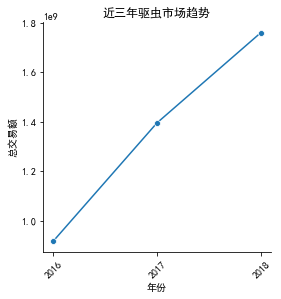

In [32]:
plt.rcParams['font.sans-serif'] = 'simhei'
sns.relplot('year','colsum',data=byyear,kind='line',height=4,marker='o')
plt.title('近三年驱虫市场趋势')
plt.xticks(byyear.year,rotation=45)   # x轴刻度值和旋转角度设置
plt.xlabel('年份')
plt.ylabel('总交易额')
plt.show()

### 查看各类目市场三年内销售额总和的变化趋势

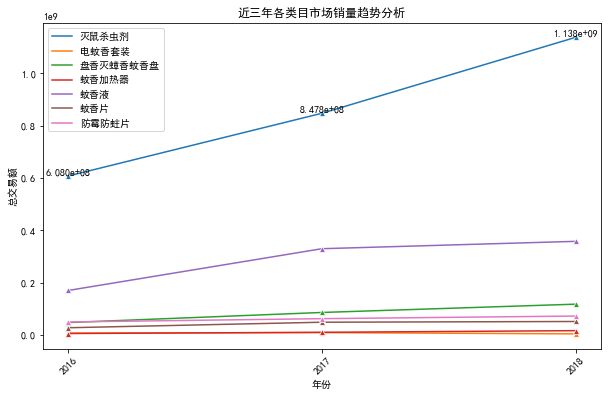

In [44]:
plt.subplots(figsize=(10,6))  # 设置绘图大小
# 没有说明X轴与Y轴的数据，则源数据的索引值作为X轴的数据，每一列的值作为Y轴的数据
# dashes设为False,因为默认只能显示6种种类，设置dashes为False后，不区分线型
sns.lineplot(data=byyear.set_index('year').iloc[:,:-1],marker="^",dashes=False)

for x,y in zip(byyear['year'],byyear['灭鼠杀虫剂']):
    plt.text(x,y,'%.3e'%y,ha='center',va='bottom')  # 在图中(x,y)位置加入文本

plt.title('近三年各类目市场销量趋势分析')
plt.xlabel('年份')
plt.ylabel('总交易额')
plt.xticks(byyear.year,rotation=45)
plt.show()

### 查看各类目市场三年内销售额总和的占比

In [45]:
byyear

,year,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片,colsum
0,2016,6.080471e+08,7666572.12,4.785285e+07,5.905205e+06,1.704905e+08,27980839.47,50023001.94,9.179661e+08
1,2017,8.477740e+08,9377531.68,8.635539e+07,1.055284e+07,3.300656e+08,49068587.96,62678822.18,1.395873e+09
2,2018,1.137893e+09,4537682.09,1.180885e+08,1.683672e+07,3.582077e+08,51845921.56,72701365.23,1.760111e+09


In [50]:
# 每个种类在当年的销售额占比
byyear_per = byyear.iloc[:,1:-1].div(byyear['colsum'],axis=0)  
byyear_per

,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
0,0.662385,0.008352,0.052129,0.006433,0.185726,0.030481,0.054493
1,0.607343,0.006718,0.061865,0.007560,0.236458,0.035153,0.044903
2,0.646489,0.002578,0.067092,0.009566,0.203514,0.029456,0.041305


In [51]:
byyear_per.index = byyear.year  # 将byyear_per的索引值设置为byyear的year列对应的值
byyear_per

,灭鼠杀虫剂,电蚊香套装,盘香灭蟑香蚊香盘,蚊香加热器,蚊香液,蚊香片,防霉防蛀片
year,,,,,,,
2016,0.662385,0.008352,0.052129,0.006433,0.185726,0.030481,0.054493
2017,0.607343,0.006718,0.061865,0.007560,0.236458,0.035153,0.044903
2018,0.646489,0.002578,0.067092,0.009566,0.203514,0.029456,0.041305


- 直接使用byyear_per这个DataFrame画图

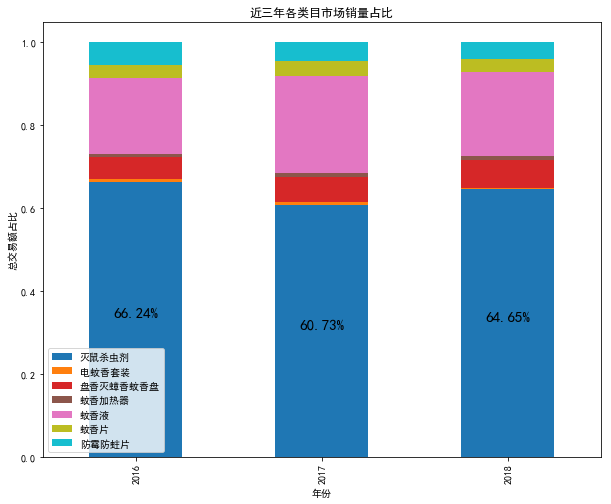

In [61]:
byyear_per.plot(kind='bar',stacked=True,figsize=(10,8),colormap='tab10')
plt.title('近三年各类目市场销量占比')
plt.xlabel('年份')
plt.ylabel('总交易额占比')
# 对于条形图，X轴位置从0开始
for x,y in zip(range(len(byyear_per)),byyear_per['灭鼠杀虫剂']):
    plt.text(x,y/2,str(round(y*100,2))+"%",ha='center',va='bottom',size=15)
plt.show()